In [1]:
import pandas as pd 
import numpy as np 
from scipy.signal import csd
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from numpy.linalg import inv
import itertools

In [2]:
covid_data= pd.read_csv("data/us.csv")
n_rows = len(covid_data)
daily_cases = covid_data["cases"].diff(1)
daily_deaths = covid_data["deaths"].diff(1)
covid_data["daily_cases"] = daily_cases
covid_data["daily_death"] = daily_deaths
covid_data = covid_data.fillna(0)
## replace initial NaN with 0 
# covid_data["daily_cases"][0] = 0 
# covid_data["daily_death"][0] = 0 


In [3]:
covid_data["deaths"][783] - covid_data["deaths"][782]

-2435

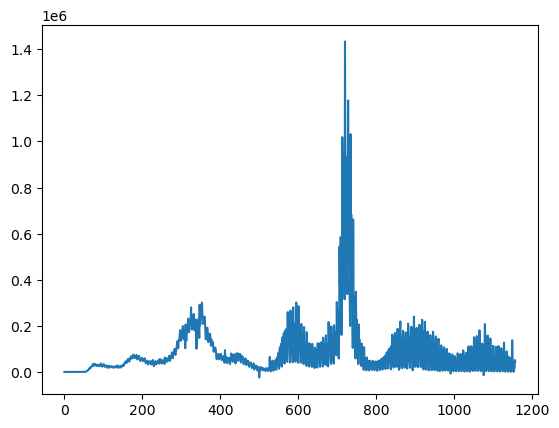

In [4]:
plt.plot(covid_data["daily_cases"])
#plt.plot(covid_data["deaths"])

In [40]:
have_ran = True 
def dateNum(date):
    m_day = datetime.date(2022,6,2)
    parts = date.split("-")
    day = datetime.date(int(parts[0]),int(parts[1]),int(parts[2]))
    return (m_day - day).days
if not have_ran:
    tweets = pd.read_csv("data/tweetid_userid_keyword_sentiments_emotions_United States.csv")
    tweets["emotion"] = tweets["emotion"].fillna("N")
    tweets_data = dict() 
    def convertor(x):
        if(x in [-2,-1,0,1,2]):
            return [-2,-1,0,1,2].index(x)
        elif(x in ["N", "S", "H", "A","F"]):
            return ["N", "S", "H", "A","F"].index(x)+5
        else:
            print("Oh no this shound't happen at ", x )
            

    for i in range(n_tweets):
        day = tweets["tweet_timestamp"][i].split(" ")[0]
        sent = tweets["sentiment"][i] 
        emote = tweets["emotion"][i] 
        if(day in tweets_data):
            tweets_data[day][convertor(sent)] += 1
            tweets_data[day][convertor(emote)] += 1
        else: 
            arr = [0 for i in range(10)]
            arr[convertor(sent)] = 1 
            arr[convertor(emote)] = 1
            tweets_data[day] = arr.copy() 
    n = len(tweets_data)
    dates = ["" for i in range(n)] 


    measurement = np.zeros((n, 10))

    for tweet in tweets_data:
        i = dateNum(tweet)
        measurement[i, :] = tweets_data[tweet]
        dates[i] = tweet 
    twitter_cleaned = pd.DataFrame(measurement,
                                columns=["-2_sent","-1_sent","0_sent",
                                            "1_sent","2_sent",
                                            "N", "S", "H", "A","F"] )
    twitter_cleaned.insert(0, "Date", dates)
    twitter_cleaned.to_csv("data/twitter_aggr.csv")
else: 
    twitter_data = pd.read_csv("data/twitter_aggr.csv")

In [41]:
covid_data["date"][863]

'2022-06-02'

In [42]:
emotions = ["N", "S", "H", "A", "F"]
sents = ["-2_sent", "-1_sent", "0_sent", "1_sent", "2_sent"]
sum(np.sum(pd.DataFrame(twitter_data, columns=emotions)))

68935089.0

In [74]:
#keys =  {0 : "-2_sent", 1 : "-1_sent", 2 : "0_sent", 3 : "1_sent", 4 : "2_sent" 
 #        ,7 : "A", 8 : "H", 9 : "S", 10 : "N", 11 : "F"}
keys = {0 : "A", 1 : "H", 2 : "S", 3 : "N", 4 : "F" }
n = len(keys)+2
data = np.zeros((n,len(twitter_data["A"])))
for i in range(n):
    if(i==5):
        data[i,:] = covid_data["daily_cases"][7:864]
    elif(i==6):
        data[i,:] = covid_data["daily_death"][7:864]
    else: 
        data[i,:] = twitter_data[keys[i]]
          

In [75]:
n = len(keys) + 2 
freqs = [i*10 for i in range(1,13)]
Pxys = np.zeros((n,n,129), dtype=np.complex64)
Pxy_max = np.zeros((n,n), dtype=np.complex64)
for i in range(n):
    for j in range(n):
        f, cxy = csd(data[i,:],data[j,:])
        Pxys[i,j,:] = cxy 
for i in range(n):
    for j in range(n):
        Pxy_max[i,j] = np.max(Pxys[i,j,freqs])


In [76]:
def insert_diag(M):
    n = len(M)
    A = np.zeros((n+1,n+1), dtype=np.complex64)
    for i in range(n):
        for j in range(0,i):
            A[i,j] = M[i,j] 
        for j in range(i+1, n+1):
            A[i,j] = M[i, j-1]
    return A 
### 60 is an arbitrary frequency to check
def wiener_project(csd_data, freq=60):
    n = len(csd_data)
    result = np.zeros((n,n), dtype=complex)
    for i in range(n):
        mxx = np.zeros((n-1,n-1), dtype=np.complex64)
        c = 0 
        for j in range(n):
            if(j==i): continue
            d = 0
            for k in range(n):
                if(k==i): continue
                mxx[c,d] = csd_data[j,k,freq]
                d += 1
            c += 1 
        fil = [j for j in range(n) if j!=i]

        result[i, fil] =  csd_data[i,fil,freq] @ inv(mxx)
    return result



In [89]:
def adj(data, i, ex=-1):
    lst = []
    for j in range(6):
        if(j == ex or j == i):
            continue
        if(data[i,j] == 1):
            lst.append(j)
    return lst 

def max_adj(data):
    adjs = np.sum(data, axis=0)
    return np.max(adjs) 

def project(csd_data, data, i, subspace_idx,freq=45):
    n = len(subspace_idx)
    v =   csd_data[i, subspace_idx]
    M = np.zeros((n,n), np.complex64)
    for j in range(n):
        for k in range(n):
            M[j,k] = csd_data[subspace_idx[j], subspace_idx[k]]
    Minv = inv(M)
    return v @ Minv @ data[:, subspace_idx].T



def seps(csd_data, data , x : int ,y : int , subset : list ):
    xz = project(csd_data, data, x, subset)
    xyz = project(csd_data, data, x, [y] + subset )
    return np.linalg.norm( xyz - xz) < 350 ## not sure if it should be properly 0 or just small 

def pc1(csd_data,data): 
    n = len(data)
    G1 = np.ones((n,n)) - np.eye(n,n)
    seperators = {}
    depth = 0
    while(max_adj(G1) >= depth ): 
        for x in range(n):
            for y in range(n):
                if(G1[x,y] == 0): continue 
                if(sum(G1[x,:]) - 1 >= depth ): 
                    lst = adj(G1, x, y)
                    for s in itertools.combinations(lst, depth):
                        if(seps(csd_data,data, x, y, list(s))):
                            G1[x,y] = 0 
                            G1[y,x] = 0
                            seperators[(x,y)] = s
                            seperators[(y,x)] = s
        depth = depth + 1 
    ### using 2 for later parts to denote the edge is of an undirected type
    return G1, seperators 

import copy


## check if orienting j -> i makes an immortality 
def immoral_check(G, i, j):
    n = len(G)
    for a in range(n):
        ## cond: j -> i <- a and not j - a
        if(G[a,i] == 1 and ( G[a,j]==0 and G[j,a]==0 )):
            return True 
    return False 

def pc2(G1, sepers):
    n = len(G1)
    G2 = copy.deepcopy(G1)
    for i in range(n):
        for j in range(n):
            if(i==j):continue
            for k in range(n):
                if(j==k or i==k):continue
                if(G1[i,j] and G1[j,k] and not G1[i,k]):
                    if(j not in sepers[(i,k)]): 
                        G2[i,j] = G2[k,j] = 1 
                        G2[j,i] = G2[j,k] = 0 
    for i in range(n):
        for j in range(n):
            ## Edge is undirected
            if(G2[i,j] == 2):
                if(immoral_check(G2,i,j)):
                    G2[i,j] = 1 
                    G2[j,i] = 0 
    return G2 


In [90]:
g1, sepers = pc1(Pxy_max, data)

In [91]:
g1

array([[0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.]])

In [92]:
g2 = pc2(g1,sepers)

In [93]:
labels = keys 
labels[5] = "Inf"
labels[6] = "Deaths"

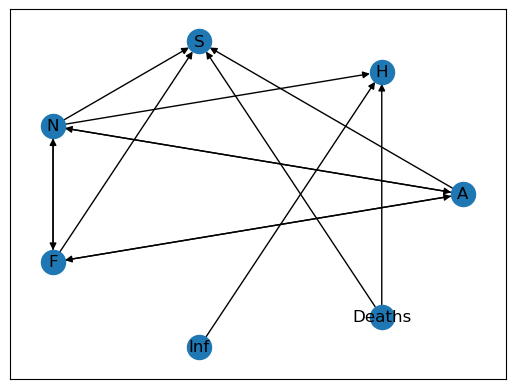

In [94]:
G = nx.DiGraph(g2)
ls = nx.circular_layout(G)
nx.draw_networkx(G, pos=ls, labels={i: labels[i] for i in range(7)})